# The Initial COVID-19 Responses of the South Korean and US Governments

## Introduction

The United States and South Korea noted their first case of the COVID-19 virus on January 20, 2020 (Holshue, 2020; Lim, 2020). The two countries responded to the virus in different ways. South Korea responded quickly with a proactive government response, combining rigorous contact tracing, early isolation, and free treatment of positive cases (Lee, 2020). The United States, on the other hand, had a delayed and disorganized response, disbanding the Pandemic Emergency Response Task Force and pushing the responsibility of containment and mitigation strategies to individual states (Florida Atlantic University, 2020). The research question this section seeks to answer is how much quicker did South Korea respond relative to the United States? 

These different responses led to each country having vastly different experiences with the virus. South Korea flattened the curve within weeks, emerging as a "model to emulate in fighting the pandemic" (You, 2020). On the other hand, the United States has emerged as the epicenter of the virus, boasting an exponentially increasing trajectory of infection cases (Balogun, 2020). To date, the US has experienced over ten million total cases and over 200,000 deaths related to the virus. In August, the US was found to account for 25 percent of COVID-19 cases and deaths in the world while comprising less than 5% of the global population (Florida Atlantic University, 2020). 

I examine how fast the South Korean and United States governments responded after the first case of COVID-19 (January 20, 2020), with respect to different government response indicators. A comparison of the South Korean and United States' government responses is especially compelling because the two countries had the same date of first COVID-19 infection, and yet the former is viewed as a success story while the latter is viewed more as a failure. I inquire as to whether faster government response leads to a more successful COVID-19 containment response in the context of these two countries. 



## Data Analysis

The government response indicators used in this project are derived from the Oxford COVID-19 Government Response Tracker (Mahdi et al., 2020). More details about the specific indicators are listed in the [GitHub codebook](https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md) in the `government response` table (Codebook, 2020). In this paper, I look specifically at the "Containment and closure policies", which are the policies that mention closures of various institutions (i.e. schools, workplaces, public transportation, etc). 

I am interested in the initial response of the two countries' governments to COVID-19, and therefore query for all data from the `government_response` prior to May 1, 2020. "Days since first infection" was determined by finding the difference of the date of each government response from January 20, 2020.

I extract information on the following government flags: school closures, workplace closures, public event cancellations, public transportation closures, stay at home requirements, internal movement restrictions, and international travel controls. Each flag can have multiple levels of restrictions, with higher values corresponding with more severe restrictions; for example, `1` denotes *recommended* school closures, whereas `2` denotes *required* school closures. I calculate the first instance of each stringency level of government response for each of the specified government flags. Using this information, I calculate the number of days it respectively took the South Korean and US governments to to implement each response.

In the case where one country has no response indicated, I fill the null value with 0 under the assumption that null values indicate an intentional lack of response rather than missing data.
nsportation, because cases were relatively under control. 

In [1]:
import os
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import psycopg2
import re
from datetime import datetime

sns.set()
sns.set_style("darkgrid")

### Load govtrack table for US and South Korea

In [2]:
conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19')
cur = conn.cursor()

In [3]:
sql_command = """SELECT * FROM government_response\
    WHERE date < '2020-05-01' and (country = 'United States' or country='South Korea')\
    ORDER by date ASC"""
df_govtrack = pd.read_sql(sql_command, conn)

# convert to datetime
df_govtrack.date = pd.to_datetime(df_govtrack['date'])

# calculate the timedelta of each response to first covid case
df_govtrack['response_since_first_infection'] = df_govtrack['date'] - datetime(2020, 1, 20)

### Plot Government Response Indicator for South Korea and US
`government_response_index` is an aggregate government response indicator calculated by OxCOVID19. We can see that South Korea takes government action quicker than the US. In fact, the US does not begin ramping up its response until early- to mid-March.

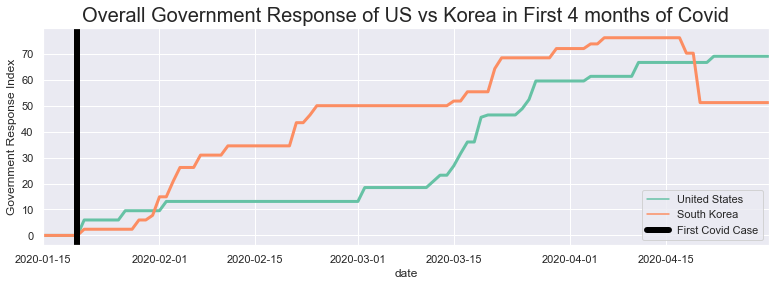

In [4]:
sns.set(rc={'figure.figsize':(13, 4)})

ax = sns.lineplot(data=df_govtrack, x="date", y="government_response_index", 
                  hue="country", palette="Set2", lw=3)

# Plot the "first day of contact"
ax.axvline(pd.to_datetime('2020-01-20'), 
           color='black', lw=6, label="First Covid Case")

# Legends, titles, axes
plt.legend()
plt.ylabel('Government Response Index')
plt.xlim(pd.to_datetime('2020-01-15'), pd.to_datetime('2020-04-30'));
plt.title('Overall Government Response of US vs Korea in First 4 months of Covid', 
          fontsize=20);

### Extract each of the c_xxxx flags mentioned in the government response tracker

In [5]:
gov_flags = [re.search("c\d_[^flag]\w*", col).group() \
             for col in df_govtrack.columns if re.match("c\d_[^flag]\w*", col)]
display(gov_flags)

['c1_school_closing',
 'c2_workplace_closing',
 'c3_cancel_public_events',
 'c4_restrictions_on_gatherings',
 'c5_close_public_transport',
 'c6_stay_at_home_requirements',
 'c7_restrictions_on_internal_movement',
 'c8_international_travel_controls']

In [6]:
# Extend gov_flags to include other relevant column indexes 
gov_flags.extend(["date", "response_since_first_infection", "country"])

# Get the containment and closure policies on each row for each flag
df_melt = df_govtrack[gov_flags].sort_values(by="date")\
    .melt(id_vars=["date", "response_since_first_infection", "country"])\
    .dropna()

# Display a few elements
# display(df_melt.tail(3))

In [7]:
# Format the labels to capitalize each word
labels = [' '.join([a.capitalize() for a in c.split('_')[1:]]) \
                   for c in df_melt.variable.unique()]

### Calculate each country's first response for each category and restriction level

In [8]:
# First instance of response per country, for each restriction level
first_restrictions_by_country = df_melt[df_melt.value!=0]\
    .groupby(['variable', 'country', 'value'])\
    .first()

# display(first_restrictions_by_country)

In [9]:
# First instance of response per country, regardless of restriction level
first_restrictions_all_levels = df_melt[df_melt.value!=0]\
    .groupby(['variable', 'country'])\
    .first()\
    .unstack()["response_since_first_infection"]

# fill nulls with "0 days" for easier analysis
first_restrictions_all_levels.fillna(pd.Timedelta(seconds=0), inplace=True)

first_restrictions_all_levels["response_difference"] = \
    first_restrictions_all_levels["United States"] - \
    first_restrictions_all_levels["South Korea"]

# display(first_restrictions_all_levels)

In [10]:
# Average time for response across all indicators and response levels
first_restriction_average = df_melt[df_melt.value!=0]\
    .groupby(['variable', 'country'])\
    .first()\
    .unstack()[["response_since_first_infection"]]\
    .mean()\
    .unstack(0)
first_restriction_average["avg_first_response_in_days"] = \
    first_restriction_average["response_since_first_infection"].dt.days

display(first_restriction_average[["avg_first_response_in_days"]])

,avg_first_response_in_days
country,
South Korea,25
United States,54


### Render Graphs

In [11]:
def add_line(**kwargs):
    plt.axvline(pd.to_datetime('2020-01-20'), lw=6, label="First Covid Case");

def render_figure_1_1():
    x_vars = "date"
    y_vars = df_melt.variable.unique()

    # Seaborn facetgrid for each variable
    g = sns.FacetGrid(df_melt, col="variable", height=1.5, col_wrap=1, aspect=7)
    # Add a line for the First Covid Case
    g.map(add_line, color='black')

    # Lineplot for each government response
    g.map_dataframe(sns.lineplot, x="date", y="value", 
                    hue="country", palette="Set2", lw=3) 
    g.set_axis_labels("Date", "Response")
    g.set(xlim=(pd.to_datetime('2020-01-15'), pd.to_datetime('2020-04-30')), 
          yticks=[1,3,5])

    # Format subplot titles
    g.set_titles(col_template="{col_name}", row_template="{row_name}", y=0.75) 

    # Add legends and titles
    g.add_legend()
    plt.subplots_adjust(top=0.95)
    g.fig.suptitle('Figure 1.1: Detailed Government Response of US vs Korea in First 4 months of Covid', 
                   fontsize=20);

In [12]:
df_bar_data = first_restrictions_all_levels.reset_index()\
        .melt(id_vars=["variable"], value_vars=["South Korea", "United States"])
df_bar_data.sort_values(by=["variable", "country"], inplace=True)
df_bar_data.reset_index(inplace=True, drop=True)

# Map days (datetime object) to integers
df_bar_data["value"] = df_bar_data["value"].apply(lambda a: a.days)

In [13]:
def render_figure_1_2_left(ax):
    g = sns.barplot(ax=ax,
                    data=df_bar_data,
                    y="variable",
                    x="value",
                    ci=False,
                    alpha=0.7,
                    hue="country",
                    palette="Set2",
                    orient='h')

    # Add the values
    for index, row in df_bar_data.iterrows():
        g.text(row.value+2, 
               index/2-0.15, 
               row.value, 
               color='dimgray', 
               fontsize=15, 
               ha="center")

    g.set_yticklabels(labels)

    # Add labels and title
    g.set_xlabel('Num Days for Response since First Covid Case')
    g.set_ylabel('Government Response Type')
    
    return g

def render_figure_1_2_right(ax):
    g = sns.barplot(ax=ax,
                    data=df_bar_data,
                    y="country", 
                    x="value", 
                    alpha=0.7,
                    hue="variable", 
                    palette="Set2", 
                    ci=False,
                    orient='h')

    for i in range(len(g.patches)):
        g.text(y=g.patches[i].get_y()+0.07, 
               x=g.patches[i].get_x()+g.patches[i].get_width()+2, 
               s=int(g.patches[i].get_width()),
               color='dimgray',
               fontsize=15,
               ha='center')


    # Format labels in legend properly
    leg = plt.legend(loc='upper right')
    [leg.get_texts()[i].set_text(label) for i, label in enumerate(labels)]

    g.set_ylabel('Country')
    g.set_xlabel('Num Days for Response since First Covid Case')
    g.set_xlim(0, 90)

    return g

def render_figure_1_2():
    # Plot barplot
    fig, ax = plt.subplots(1,2, figsize=(18, 8))
    g0 = render_figure_1_2_left(ax[0])
    g1 = render_figure_1_2_right(ax[1])
    fig.suptitle('Figure 1.2: Government Response of US vs Korea in First 4 months of Covid, By Response Type',
              fontsize=20);
    fig.tight_layout(pad=3.0)

In [14]:
# render_figure_1_1()
# plt.savefig('img/1_1.png')
# render_figure_1_2()
# plt.savefig('img/1_2.png')

## Results

Despite both South Korea and the United States having confirmed their first case of COVID-19 on the same day, the difference in responses of the two governments is evident in the following analyses. On average, the US took twice as long (54 days) as Korea (25 days) to respond.

`Figure 1.1` shows the "first" day that each country's government started implementing a response, and also when the level of that response changed. In general, South Korea responded a lot earlier than the US did for nearly every category. Even as the level of restrictions within each category shifted,  South Korea's restriction levels tended to stay higher than the US's restriction levels. In some cases (such as in enacting school closure restrictions), South Korea responded up to 39 days faster than the US did. 

There were only two areas in which this pattern did not hold. The first was in the case of public transportation, in which case South Korea did not enforce any restrictions at all. This is because South Korea indeed did not implement public transportation restrictions during the first few months of the COVID-19 pandemic, perhaps due to the fact that mask use was compulsory in public places (Tirachini, 2020). In this case, perhaps having no response was a better indicator of COVID-19 success than having a stringent response. The second was in the case of international travel restrictions, in which the US responded swiftly and promptly, a few days before South Korea's response. 

![Figure 1.2](img/1_1.png)

`Figure 1.2` shows each government's response to each of the given government response indicators. I use the first response regardless of response severity level. The two graphs show the same information, except the one on the left is grouped by restriction, and the one on the right is grouped by country.

We can determine that although South Korea tended to respond anywhere from 17 to 39 days faster than the United States in terms of nearly all categories of government response, there are two exceptions. These exceptions align wtih the observations made in `Figure 1.1`. First, South Korea did not implement public transportation restrictions. Second, the only category in which the United States responded faster than South Korea was in "international travel controls." According to the US Department of State, President Trump issued the first COVID-19-related proclamation in January 31, 2020, which blocked entry into the US of foreigners who were present in China (Travel.state.gov., 2020). This proclamation went into effect on February 2.

![Figure 1.2](img/1_2.png)

## Limitations and Future Directions

### Factors Not Included in this Analysis
Before positing South Korea's relative success dealing with COVID-19 was caused by faster government response, it is important to take other factors into account. In this analysis, I did not investigate other factors that may have impacted the two governments' responses, such as increase in COVID-19 cases, the public government approval ratings, the proportion of elderly and vulnerable citizens in the population, and the country's history of past pandemics.

In this analysis, I also did not take into account the population size of the respective countries nor of their government structures. The US is a federal republic, meaning that responsibility and power is divided between the central government and the states. Individual states or local governments may have had earlier responses to the pandemic before the central government responded. While state-level and territory-level data is included in the government response table, local-level responses are likely to not be included (Hale et al., 2020)

Conversely, South Korea is a centralized democratic republic with a smaller population than the US. This difference in population size and centrality of the federal government probably had an effect on the various government responses to the pandemic as well.

Another limitation of this analysis is that, in quantifying the "first response time", I did not take into account the level of severity of the actions. For example, the chart in `Figure 1.2` does not take into account that South Korea's first response to school closure was at a Level 3, while the US's first response to school closure was at a Level 1. While this was necessary for easy comparison, it is important to acknowledge the nuance lost by ignoring the stringency levels.


### Validity of Data Sources
The government responses from the database are labeled as discrete values ranging on a scale from 0 to 3 or 4 (depending on the indicator). Because responses had to be mapped to these values, we lose information on the details/specifics of each country's response. We only know the general level of stringency and category of the government response, but we do not know any details beyond that. Indeed, the the group at the Blatnavik School of Government responsible for collecting government response data acknowledges in their working paper the challenges of measuring the diversity of governments' responses to COVID-19 in a systematic way, and of the abstraction of the nuances of these responses in using composite measures (Hale et al., 2020). We also lose an additional level of nuance because state and national government responses were aggregated in government response data without being separable.

It is also important to acknowledge the likelihood of data inaccuracies in the OxCOVID19 database government response indicators. The data in this table were manually collected by a team at Oxford via Internet searches of public news articles and government press releases (Hale et al., 2020). There are bound to be some inadvertent mistakes by incorrectly including responses or neglecting to include responses.


### Future Directions

As discussed, other factors likely contribute to the relationships we observed, and additional analyses would contribute to this understanding.  Examples of other factors to be included in this analysis include topics of each government's official announcements and sentiments of the reactions from each country's public. This analysis can be extended by seeing how these sentiments or topics change over time for each country, as more scientific research emerges about COVID-19 and as the severity of the global pandemic increases over time.

# The Relationship between Democracy Index and Restrictive Measures in Response to COVID-19 

## Introduction

In the many months since the first outbreak of the COVID-19 pandemic, scholars have pondered the indicators that could be used to predict countries' varying responses and experiences. An article published in May 2020 suggests that democratic governments (rather than authoritarian governments, such as China's) are the key to a successful response for controlling the pandemic, due to democracy's accountability to the people (Alon et al., 2020). Research from the Carnegie Endowment for International Peace offers a more critical view, arguing that even democratic countries such as South Korea and Italy employed methods bordering on authoritarianism, such as privacy-invasive digital contract tracing apps or criminal penalties for breaking quarantine (Kleinfeld, 2020). The research question this section seeks to answer is whether the country's democracy index is correlated with a quicker tendency to enact strict restrictions on internal movement.

In this section, I continue the analyses in Part 1 to examine the relationship between government response to COVID-19 and country's level of democracy. I will examine whether the regime type of a government, as described by the Economist's Democracy Index (EIU), has an impact on that government's response. What the data show aligns with an article published in August 2020: that democratic and authoritarian governments have their own strengths and weaknesses, and that neither is better at dealing with the threat of COVID-19 (Stasavage, 2020). While authoritarian governments' centralized power allows for decisive action, their propensity for secrecy may allow for suppression of information. While democratic governments' transparency allows for greater knowledge of threats, decentralization of power may lead to slower and inefficient response.

I focus specifically on stringent restrictions on internal movements within the country (i.e. Level 2 or above, as indicated by the government response metrics mentioned in Part I). I aim to investigate whether a country's government (and the democracy level of that government) can explain that country's willingness to impose stringent government controls. Do authoritarian countries tend to respond faster with stringent internal movement controls, and do democratic countries tend to respond slower, perhaps due to their concerns about individual freedom and privacy?

To measure democracy and regime type, I use the 2019 Democracy Index (The Economist Intelligence Unit, 2019). While the Democracy Index has its own criticisms and limitations (which will be discussed in the Limitations section below), several studies, including that of Bashar and Tsokos (2019), claim that it is the most comprehensive democracy indicator. The EIU's Democracy Index ingests 60 different indicators for each country to calculate  a numeric score representing democracy. This democracy score can be mapped to a regime type: Full Democracy, Flawed Democracy, Hybrid, and Authoritarian.

## Data Analysis

In this analysis, data is collected from three main sources.

First, I obtain the EIU's Democracy Index its Wikipedia page. While the EIU's website contains a whitepaper with their data, they do not have a public CSV file or API available on their whitepaper or their website. The most recent version on Wikipedia was sourced on 2020-02-04 from the EIU's report (Democracy Index, 2020). 

Second, I determine the first COIVD-19 case found in each country from the epidemiology data present in the OxCOVID19 database. I do this by determining the first entry with more than 0 number of cases.

Third, I calculate the stringency of internal movements using data related to government response from the OxCOVID19 database. This specific indicator can take one of the following values: 0 (no measures), 1 (recommended not to travel between regions/cities), 2 (internal movement restrictions in place), and Blank (no data) (Codebook, 2020). For this analysis, I focus on Level 2 restrictions because I aim to examine the most stringent measures by governments to make my connection with authoritarianism.

In merging the data from the Democracy Index and the OxCOVID19 database, I found several countries with missing data. This will be addressed further in the Limitations section. 

In [15]:
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import psycopg2
import re
import datetime as dt
from bs4 import BeautifulSoup

sns.set()
sns.set_style("darkgrid")

### Obtain Democracy Index

In [16]:
# Scraping democracy index from Wikipedia page
response = requests.get("https://en.wikipedia.org/wiki/Democracy_Index")
soup = BeautifulSoup(response.text)

countries, scores, regimetypes, regions = [], [], [], []

for line in soup.find_all("table")[2].find_all("tr")[1:]:
    country = line.find("a").text
    score, regimetype = [a.text for a in line.find_all("b")]
    
    table_items = [t.text for t in line.find_all("td")]
    table_items = [i for i in table_items if 'Score:' not in i]
    
    countries.append(country)
    scores.append(score)
    regimetypes.append(regimetype)
    regions.append(table_items[-1].strip('\n'))

    # Last country in the table
    if country == "North Korea": break

In [17]:
# Convert democracy index lists into dataframe
dem_index = pd.DataFrame([countries, scores, regimetypes, regions]).T
dem_index.columns=["country", "dem_score", "regimetype", "region"]
dem_index.dem_score = dem_index.dem_score.apply(float)

### Load Government Response and Epidemiology from OxCOVID19

In [18]:
conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19')
cur = conn.cursor()

In [19]:
# Load government tracking data from OX COVID
sql_command_all = """SELECT * FROM government_response\
    WHERE date < '2020-04-01'\
    ORDER by date ASC"""
df_govtrack_all = pd.read_sql(sql_command_all, conn)

# to datetime
df_govtrack_all.date = pd.to_datetime(df_govtrack_all['date'])
df_govtrack_all.government_response_index = df_govtrack_all.government_response_index.apply(float)

In [20]:
# Load epidemiology data from OX COVID
sql_command_epi = """SELECT * FROM epidemiology WHERE date < '2020-04-01' ORDER by date DESC"""
df_epidemiology = pd.read_sql(sql_command_epi, conn)

# to datetime
df_epidemiology.date = pd.to_datetime(df_epidemiology['date'])

### Determine "first case of COVID-19" for each country

In [21]:
# Determine "first case of covid" for each country
first_confirmed = df_epidemiology[df_epidemiology.confirmed>0]\
    .sort_values(by="date")[["country", "date", "confirmed", "gid"]]\
    .groupby("country")\
    .first()

# Extract GIDs from arrays for each row
first_confirmed.gid = first_confirmed.gid.dropna().apply(lambda x: x[0])

# Drop rows with null GIDs. These are continents (ex: Africa, America, etc)
first_confirmed = first_confirmed[~first_confirmed.gid.isna()]

# Some GIDs are have extra numbers after them, get rid of them (ex: POL.3.6_1)
first_confirmed.gid = first_confirmed.gid.apply(
    lambda x: re.search("(\w\w\w)",x).group(1))

### Filter for first record of government's restrictions on internal movement

In [22]:
# Selecting only "Restrictions on internal movement" government flag
gov_flags = ['c7_restrictions_on_internal_movement']
gov_flags.extend(["date", "country", "gid"])

# Dataframe with all of the government flags from above, melted
df_melt_all = df_govtrack_all[gov_flags]\
    .sort_values(by="date")\
    .melt(id_vars=["date", "country", "gid"])\
    .dropna()

# Merge in first confirmed date for each country
df_melt_all = df_melt_all.merge(first_confirmed, how="left", on=["gid"])\
    .rename(columns={"date_x": "date", "date_y": "first_confirmed_date"})\
    .drop(columns="confirmed")

# Calculate the number of days for each 
df_melt_all["response_since_first_infection"] = \
    df_melt_all["date"] - df_melt_all["first_confirmed_date"]

In [23]:
# The countries that do not seem to exist in the OxCovid database
df_melt_all[df_melt_all.first_confirmed_date.isna()].country.unique()

array(['Pitcairn Islands', 'Yemen', 'Vanuatu', 'Solomon Islands',
       'South Sudan', 'Turkmenistan', 'Falkland Islands', 'Malawi',
       'Macao', 'Lesotho', 'Hong Kong', 'Tajikistan'], dtype=object)

### Merge in data about first confirmed COVID-19 case and Democracy Index

In [24]:
# Only looking at values above a 1 in score (i.e. most stringent scores)
# 1=Recommended, 2=Restricted
df_all_countries= df_melt_all[df_melt_all.value>1]\
    .groupby(['variable', 'country'])\
    .first()\
    .unstack()["response_since_first_infection"]\
    .melt()\
    .rename(columns={"value": "response_since_first_infection"})

# Extract just the number of "days" from the time detla
df_all_countries["response_since_first_infection"] = \
    df_all_countries["response_since_first_infection"].apply(lambda a: a.days)

# Drop the countries with no data about confirmed cases
df_all_countries = \
    df_all_countries[~df_all_countries["response_since_first_infection"].isna()]

# Merge back in the date of the first case of covid
df_all_countries = df_all_countries\
    .merge(first_confirmed.reset_index()[["country", "gid", "date"]], 
           on="country")\
    .rename(columns={"date": "first_case"})

In [25]:
# Merge in democracy score
df_merge = df_all_countries.merge(dem_index, on="country")


### Convert "first case" date to different time frames for extra analysis

In [26]:
# week of year
df_merge['first_case_woy'] = df_merge.first_case.dt.isocalendar().week 

# every [two weeks] of year
df_merge['first_case_biweekly'] = df_merge.first_case_woy//2

# month of year
df_merge['first_case_month'] = df_merge.first_case.dt.month    

# date as ordinal
df_merge['first_case_ordinal'] = pd.to_datetime(df_merge['first_case'])\
    .apply(lambda date: date.toordinal())                               


# A ranking/ordering for regime type in order of authoritarian to democratic
regimetype_order = {"Authoritarian": 0, "Hybrid regime": 1, 
                    "Flawed democracy": 2, "Full democracy": 3}
df_merge["regimetype_order"] = df_merge.regimetype.map(regimetype_order)

### Calculate average response time before and after Feb 15 for each regime type


In [27]:
average_response_time_before_feb_15 = \
    df_merge[df_merge.first_case < datetime(2020,2,15)]\
    .groupby(["regimetype_order", "regimetype"])\
    .mean()["response_since_first_infection"]\
    .to_frame()\
    .rename(columns={"response_since_first_infection": "avg_response_days"})\
    .apply(lambda x: round(x, 2))\
    .reset_index()\
    .drop(columns=["regimetype_order"])

average_response_time_after_feb_15 = \
    df_merge[df_merge.first_case >= datetime(2020,2,15)]\
    .groupby(["regimetype_order", "regimetype"])\
    .mean()["response_since_first_infection"]\
    .to_frame()\
    .rename(columns={"response_since_first_infection": "avg_response_days"})\
    .apply(lambda x: round(x, 2))\
    .reset_index()\
    .drop(columns=["regimetype_order"])

### Top 3 Countries Per Regime Type with Fastest and Slowest Responses

In [28]:
fastest_by_regimetype = df_merge\
    .sort_values(by="response_since_first_infection")\
    .groupby("regimetype")\
    .head(3)
fastest_by_regimetype['speed'] = 'fast'

slowest_by_regimetype = df_merge\
    .sort_values(by="response_since_first_infection")\
    .groupby("regimetype")\
    .tail(3)\
    .sort_values(by="regimetype")
slowest_by_regimetype['speed'] = 'slow'

top_response_by_regimetype = fastest_by_regimetype\
    .append(slowest_by_regimetype)\
    .sort_values(by=["speed", "regimetype_order", "first_case"])\
    [["country", "response_since_first_infection", "first_case", "regimetype"]]
top_response_by_regimetype.reset_index(inplace=True, drop=True)

### Calculate Other Helper Variables

In [29]:
# order of regimes from most to least authoritarian; used for plotting purposes
regime_order = ["Authoritarian", "Hybrid regime", 
                "Flawed democracy", "Full democracy"]

### Render Graphs

In [30]:
def render_figure_2_1():
    a4_dims = (10, 5)
    fig, ax = plt.subplots(figsize=a4_dims)

    g = sns.boxplot(ax=ax, x="regimetype", y="response_since_first_infection", 
                    order=regime_order,
                    data=df_merge, palette="Set1")
    plt.xlabel('Regime Type')
    plt.ylabel('Response Time (Days) Since First Covid Case')
    plt.title('Figure 2.1: Response Time for Internal Restriction Measures, by Regime Type', 
              fontsize=20);

In [31]:
def render_figure_2_2():
    df_merge_months = df_merge.copy()

    # Special case: China's first case was december 31, 2019. 
    # We will interpret this as january
    df_merge_months.loc[df_merge_months.country=="China", 
                        "first_case_month"] = 1

    fig, ax = plt.subplots(1,2, figsize=(18,8))

    g0 = sns.boxplot(x="first_case_month", y="response_since_first_infection",  
                     hue_order=regime_order, hue="regimetype", ax=ax[0],
                     data=df_merge_months, palette="Set1")

    g1 = sns.stripplot(x="first_case_woy", y="response_since_first_infection", 
                       zorder=1, size=14, linewidth=1, hue="regimetype", 
                       ax=ax[1], dodge=True,hue_order=regime_order, 
                       data=df_merge_months, palette="Set1")

    g0.set_title('Response Time (By Month)')
    g1.set_title('Response Time (By Week)')

    g0.set_xlabel('First Case of Covid (Month of Year)')
    g1.set_xlabel('First Case of Covid (Week of Year)')

    g0.set_ylabel('Response Time Since First Case (Days)')
    g1.set_ylabel('Response Time Since First Case (Days)')

    fig.suptitle('Figure 2.2: Response Time, by Regime Type and First Covid Case', 
                 position=(.5,1), fontsize=20);

In [32]:
def plot_barplot_subplot(df, ax, title_suffix):
    g = sns.barplot(x="regimetype", y="avg_response_days", data=df, 
                    ax=ax, palette="Set1")

    for index, row in df.iterrows():
        g.text(row.name, row.avg_response_days+1, row.avg_response_days, 
               color='black', fontsize=15, ha="center")
    
    ax.set_ylim(0,80)
    ax.set_ylabel("Average Response Time (Days)")
    ax.set_xlabel("Regime Type")
    ax.title.set_text(f"Countries with First Case {title_suffix}")
    
def render_figure_2_3():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    plot_barplot_subplot(average_response_time_before_feb_15, 
                         axes[0], "Before Feb 15")
    plot_barplot_subplot(average_response_time_after_feb_15, 
                         axes[1], "After Feb 15")

    fig.suptitle("Figure 2.3: Average Response Times for Internal Movement Restrictions, by Regime Type", 
                 y=0.98, fontsize=20)
    fig.tight_layout()

In [33]:
def render_figure_2_4():
    plt.rcParams["figure.figsize"] = [15, 5]

    data = df_merge[["country", "response_since_first_infection", "first_case", 
                     "dem_score", "regimetype", "region"]]\
        .groupby("regimetype")\
        .apply(lambda x: x.sort_values("response_since_first_infection"))\
        .drop(columns=["regimetype"])\
        .reset_index(0).reset_index(drop=True)

    sns.kdeplot(data=data, x="response_since_first_infection", hue="regimetype", 
                hue_order=regime_order, palette="Set1", fill=True, bw_adjust=.6, 
                linewidth=3, alpha=0.1)

    plt.xlabel('Response Time Since First Infection (Days)')
    plt.title('Figure 2.4: Distribution of Response Time, By Regime Type', 
              fontsize=20);

In [34]:
def render_figure_2_5():
    # plotting inspired by https://nikkimarinsek.com/blog/how-to-make-an-arrow-plot
    data = top_response_by_regimetype
    ax = plt.figure(figsize=(8,12))
    ax = sns.stripplot(data=data, x='first_case', y='country', orient='h', 
                       size=12, hue_order=regime_order, hue='regimetype', 
                       palette='Set1')
    
    #add start points
    arrow_starts = data['first_case'].values
    arrow_lengths = data['response_since_first_infection']

    # Add number of days to the label on the y-axis
    new_labels = [f"{c.get_text()} ({val} days)" for (c, val) in \
         zip(ax.get_yticklabels(), 
             data.response_since_first_infection.values.astype(int).astype(str))]
    ax.set_yticklabels(new_labels)

    #add arrows to plot
    for i, subject in enumerate(data['country']):
        if arrow_lengths[i] != 0:
            ax.arrow(arrow_starts[i],        #x start point
                     i,                      #y start point
                     arrow_lengths[i],       #change in x 
                     0,                      #change in y
                     head_width=.3,         #arrow head width
                     head_length=1,        #arrow head length
                     width=0.01,              #arrow stem width
                     fc='gray',             #arrow fill color
                     ec='gray')             #arrow edge color
    plt.axhline(y=11.5, color='gray', linestyle='--')
    plt.xticks(rotation=45)
    plt.legend(loc="upper left", borderaxespad=0.)
    plt.xlabel('Date')
    
    
    plt.text(1.03, 0.8, 'Top 3 Countries with Fastest Responses',
        horizontalalignment='left',
        verticalalignment='bottom',
        transform=ax.transAxes)
    plt.text(1.03, 0.3, 'Top 3 Countries with Slowest Responses',
        horizontalalignment='left',
        verticalalignment='bottom',
        transform=ax.transAxes)
    
    
    plt.title('Figure 2.5: Countries with Fastest and Slowest Responses, by Regime Type', 
              fontsize=20);

In [35]:
# render_figure_2_1()
# plt.savefig('img/2_1.png')
# render_figure_2_2()
# plt.savefig('img/2_2.png')
# render_figure_2_3()
# plt.savefig('img/2_3.png')
# render_figure_2_4()
# plt.savefig('img/2_4.png')
# render_figure_2_5()
# plt.savefig('img/2_5.png', bbox_inches = "tight")

## Results

the results of the analysis as follows show that at first glance, authoritarian countries seem to have responded faster than democratic countries in enacting strict rules about internal movements. Some authoritarian countries (such as Libya and Venezuela) enacted restrictions days before reporting their first COVID-19 case. 

However, upon separating the speed of response by the date of the first COVID-19 case, we can see that the date of first infection had a large influence on quickness of response. With a later first COVID-19 infection date, the effect of regime type seems to have less of an impact on how quick a government enacts stringent internal movement restrictions. This offers a more complex view that goes beyond the democracy index calculated by the EIU. Therefore, although authoritarian countries tended to respond faster with restrictions than democratic countries, we cannot make broad claims or conclusions that authoritarian countries necessarily act quicker to enact stringent restrictions.

`Figure 2.1` groups speed of response to enact internal restriction measures by regime type. The more authoritarian the regime type of the government, the faster they tend to respond with stringent measures for internal movement. This seems to confirm the fact that authoritarian governments are likely to enact more restrictive measures, whereas democratic governments are likely to be more cognizant about citizens' privacy and freedom. However, is it accurate to conclude that authoritarian governments tend to enact restrictive movement measures faster than democratic governments? 

![Figure 2.1](img/2_1.png)

`Figure 2.2` shows the government response time, separated by regime type, with the date of the first COVID-19 case aggregated by month and by week. As the date of the first COVID-19 case gets later, the authoritarian nature of the regime seems to have less impact on response time.

In the response times aggregated by month, the mean of the authoritarian regimes' response times begins noticeably quicker than other regime types. By the third month, the means seem to equalize across all regime types. 

In the response times aggregated by week, the downward trend becomes apparent as time goes on. For the countries with earlier first COVID-19 cases (before Week 8), authoritarian regimes tended to respond quicker than other regime types as indicated by the red data points. For the countries with later first COVID-19 dates (i.e. after Week 8), the regime type tended to have less of an influence in response time, as the data points are closely clustered and less variable. 

Overall, the date of the first case of COVID-19 is influential upon the number of days it took for a government to enact restrictions, although the regime type of that government is not negligible. One way to interpret this can be that, for countries with earlier first cases of COVID-19, the authoritarain regimes were more likely to enact stringent internal movement measures. For countries with later first cases of COVId-19, the regime type had less of an influence on stringency measures.

![Figure 2.2](img/2_2.png)

`Figure 2.3` shows a government's response to impose internal movement restrictions for countries that experienced their first case of COVID-19 before and after February 15, 2020. I chose February 15 as the cutoff, since we saw in `Figure 2.2` that around Week 8 is when behavior of clustering seemed to shift. For countries with first case before February 15, authoritarian countries responded on average around 20 days quicker. For countries with first case after February 15, all countries tended to respond quicker, with regime type having less of an influence on response time.

![Figure 2.3](img/2_3.png)

`Figure 2.4` shows the distribution of responses for each regime type. Authoritarian, hybrid, and flawed democracy regimes tend to be unimodal with long right tails, meaning that there was some unity in terms of their responses, but with some variety outside of the mode. The distribution of democratic regimes' response time, as indicated by the purple line, are less certain. The distribution of democratic regimes' response time is bimodal and variable, suggesting that the responses for different democratic regimes was very varied.

![Figure 2.4](img/2_4.png)

`Figure 2.5` plots the top 3 countries with slowest and top 3 countries with fastest response, for each regime tye. The dot indicates the date of the first COVID-19 case, and the end of the arrow indicates the date of the first response to enact internal restrictions. An arrow going to the left indicates the country having responded before their first case. Above the dotted line are the top 3 countries per regime type that responded the quickest. Below the dotted line are the top 3 countries per regime type that responded the slowest.

This graph confirms the observations made above and makes it clearer that countries with later first cases of COVID-19 responded quicker than countries with earlier first cases of COVID-19. However, even within this framework, we can note that the response of the quickest democratic countries is vastly different from the response of the quickest countries in the other 3 regime types. Even the fastest democratic countries did not respond proactively (i.e. before a confirmed case of COVID-19), whereas other regime types did.

As for countries with the slowest responses, there seems to be little variability among regime types. Countries with earlier first cases of COVID-19, regardless of regime type, tended to take a longer time to respond than countries with later first cases of COVID-19.

![Figure 2.5](img/2_5.png)

## Limitations and Future Directions

### Factors Not Included in the Analysis
Similar to Part I, there are several outstanding factors not included in my analysis. Examples of other factors to be included in this analysis include factors such as country population, COVID-19 severity, and country history with previous pandemics. Perhaps the reason South Korea responded slowly to enact stringent movement restrictions is because of other policies, or because their case numbers never rose too high. Other interesting directions to look include geographic proximity of countries to China, where the initial outbreak of the virus occurred. Perhaps one of the reasons Mongolia responded so quickly (18 days before their first COVID-19 case) was due to their sharing a border with China. 

### Validity of Data Sources

It is important to be critical of the data sources used in this analysis. I used the EIU's Democracy Index as a proxy for countries' level of authoritarianism and democracy, but there have been criticisms of the index. For example, Bashar and Tsokos (2019) suggest that the EIU's Democracy Index may not be very accurate, as it does not take into consideration the interactions and correlations among the collected data. 

There have also been some gaps in the OxCOVID19 database as well. There was no data about case numbers for the following countries: Falkland Islands, Malawi, Vanatu, Lesotho, Solomon Islands, Tajikistan, Yemen, Turkmenistan, Hong Kong, Macao, South Sudan, and Pitcairn Islands. Further, there are issues (mentioned already in Part 1's Limitation section) about loss of nuance of severity level and human transcription errors in creating the database.

Lastly, there may be concerns about the accuracy of the first case of COVID-19 calculated for each country. One study uses statistical methods to show that authoritarian governments are likely to have manipulated the data they published about their COVID-19 numbers (Kapoor et al., 2020). The dates of the first COVID-19 case may be inaccurate and the analysis of this paper misleading, due to the possibility that the data in the database are inaccurate or falsified.

### Future Directions
This study looked only at the time it took countries to enact severe restrictions on internal movement. Future research is encouraged to replicate this study for other kinds of restrictions in conjunction with World Values survey data. Do countries that value trade more tend to be slower enacting restrictions of international travel controls? Do countries that value education more tend to be slower in enacting restrictions on school closures? This analysis can be enriched with additional data about each country, such as GDP, state of health infrastructure, and history with previous pandemics. Did countries with poorer health infrastructures respond faster as a preventative measure? Did countries with previous experience with pandemics, like SARS or Zika, respond faster with contact tracing measures? There are many directions for extending this current study into new understandings about countries' responses to the global pandemic.


# Works Cited

Alon, I., Farrell, M., & Li, S. (2020). Regime Type and COVID-19 Response. FIIB Business Review, 9, 152 - 160.

Balogun, J. A. (2020). Commentary: Lessons from the USA delayed response to the COVID-19 pandemic. African journal of reproductive health, 24(1), 14-21.

Bashar, R., & Tsokos, C. (2019). Statistical Classification of Democracy Index Scores of Countries of the World.

Codebook for the Oxford Covid-19 Government Response Tracker (2020). GitHub Repository. Retrieved November 18, 2020 from https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md.

Democracy Index. (2020). Democracy Index. Retrieved November 29, 2020, from https://en.wikipedia.org/wiki/Democracy_Index. 

Florida Atlantic University. (2020, August 20). COVID-19: How South Korea prevailed while the United States failed. ScienceDaily. Retrieved November 13, 2020 from www.sciencedaily.com/releases/2020/08/200820102431.htm.

Hale, T., Webster, S., Petherick, A., Phillips, T., & Kira, B. (2020). Oxford COVID-19 Government Response Tracker, Blavatnik School of Government.

Holshue, M.L., DeBolt, C., Lindquist, S., Lofy, K.H., Wiesman, J., Bruce, H., Spitters, C.L., Ericson, K., Wilkerson, S., Tural, A., Díaz, G.T., Cohn, A., Fox, L., Patel, A., Gerber, S., Kim, L., Tong, S., Lu, X., Lindstrom, S., Pallansch, M., Weldon, W., Biggs, H., Uyeki, T.M., & Pillai, S. (2020). First Case of 2019 Novel Coronavirus in the United States. The New England Journal of Medicine, 382, 929 - 936.

Kapoor, M., Malani, A., Ravi, S., & Agrawal, A. (2020). Authoritarian Governments Appear to Manipulate COVID Data. arXiv: General Economics.

Kleinfeld, R. (2020). Do Authoritarian Or Democratic Countries Handle Pandemics Better?. Carnegie Endowment for International Peace. Retrieved November 29, 2020, from https://carnegieendowment.org/2020/03/31/do-authoritarian-or-democratic-countries-handle-pandemics-better-pub-81404.

Lee, D., Heo, K., & Seo, Y. (2020). COVID-19 in South Korea: Lessons for developing countries. World Development, 135, 105057 - 105057.

Lim, J., Jeon, S., Shin, H.Y., Kim, M.J., Seong, Y.M., Lee, W.J., Choe, K.W., Kang, Y.M., Lee, B., & Park, S.J. (2020). Case of the Index Patient Who Caused Tertiary Transmission of Coronavirus Disease 2019 in Korea: the Application of Lopinavir/Ritonavir for the Treatment of COVID-19 Pneumonia Monitored by Quantitative RT-PCR. Journal of Korean Medical Science, 35.

Mahdi, A., Blaszczyk, P., Dlotko, P., Salvi, D., Chan, T., Harvey, J., Gurnari, D., Wu, Y., Farhat, A., Hellmer, N., Zarebski, A., Hogan, B., & Tarassenko, L. (2020). OxCOVID19 Database: a multimodal data repository for better understanding the global impact of COVID-19. medRxiv.

Stasavage, D. (2020). Democracy, Autocracy, and Emergency Threats: Lessons for COVID-19 From the Last Thousand Years. International Organization, 1-17. doi:10.1017/S0020818320000338

The Economist Intelligence Unit. (2019). Democracy Index 2019. Retrieved November 13, 2020, from https://www.eiu.com/topic/democracy-index.

Tirachini, A., & Cats, O. (2020). COVID-19 and Public Transportation: Current Assessment, Prospects, and Research Needs. The Journal of Public Transportation, 22, 1.

Travel.state.gov. (2020). Presidential Proclamations On Novel Coronavirus. Retrieved November 29, 2020, from https://travel.state.gov/content/travel/en/News/visas-news/presidential-proclamation-coronavirus.html.

You, J. (2020). Lessons From South Korea’s Covid-19 Policy Response. The American Review of Public Administration, 50, 801 - 808.

# Word Counts

In [40]:
import io
from nbformat import current
nbk_path = '/Users/yenniejun/Documents/oxford/FundamentalsOfSDSInPython/oii-sds-fundamentals-summative/1361283 Fundamentals of Social Data Science Summative.ipynb'



In [42]:
with io.open(nbk_path, 'r', encoding='utf-8') as f: 
    nb = current.read(f, 'json')
    
word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        if "# Works Cited" in cell['source']: continue
        curr_wc = len(cell['source'].replace('#', '').lstrip().split(' '))
        print(cell['source'][:15], curr_wc)
        word_count += curr_wc

print(f"The word count, excluding references, is {word_count}")

## Introduction 318
## Data Analysi 256
### Plot Govern 46
Despite both So 252
![Figure 1.2](i 2
`Figure 1.2` sh 163
![Figure 1.2](i 2
### Factors Not 571
## Introduction 433
## Data Analysi 202
### Calculate a 13
the results of  153
In `Figure 2.1` 87
![Figure 2.1](i 2
`Figure 2.2` sh 243
![Figure 2.2](i 2
`Figure 2.3` sh 93
![Figure 2.3](i 2
`Figure 2.4` sh 82
![Figure 2.4](i 2
`Figure 2.5` pl 217
![Figure 2.5](i 2
### Factors Not 471
The word count, excluding references, is 3614
